# Part 1: Spam or ham? (45 marks)

In the spam literature, an email that is **not** spam is called _ham_. 

Your task is to develop a Naive Bayes classifier to determine whether a given email is spam or ham.

## The data: Spam!

The following cell loads your training data set (called _training set_).

In [9]:
import numpy as np

training_spam = np.loadtxt(open("data/training_spam.csv"), delimiter=",")
print("Shape of the spam training data set:", training_spam.shape)
print(training_spam)

Shape of the spam training data set: (1000, 55)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 1.  1.  1. ...,  1.  1.  0.]
 [ 1.  0.  0. ...,  1.  1.  1.]]


Your training set consists of 1000 rows and 55 columns. Each row corresponds to one email message. The first column is the _response_ variable and describes whether a message is spam (1) or ham (0). The remaining 54 columns are _features_ that you will use to build a classifier. These features correspond to 54 different keywords (such as "money", "free", and "receive") and special characters (such as ":", "!", and "$"). A feature has the value "1" if the keyword appears in the message and "0" otherwise.

## The model:  Naïve Bayes
Your [naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier will distinguish between two classes:

* **$C = 1$ for spam messages **
* **$C = 0$ for ham messages. **


The classifier builds a model for the probability $P(C=c\ |\ message)$ that a given message belongs to a certain class. A new message is then classified based on the Bayesian *maximum a posteriori* estimate

\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \  P(C=c\ |\ message).
\end{equation}

Using Bayes' rule we can write

\begin{equation}
P(C=c\ |\ message) = \frac{P(message\ |\ C=c)P(C=c)}{P(message\ |\ C=1)P(C=1) + P(message\ |\ C=0)P(C=0)}.  \quad \quad 
\end{equation}

The denominator is the same for both classes and we can thus drop it to get

\begin{equation}
P(C=c\ |\ message) \propto P(message\ |\ C=c)P(C=c).
\end{equation}


We represent a message using a binary [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. Specifically, a message is represented as $\mathbf{w} = (w_1, ..., w_k)$, where $w_i = 1$ if the word $w_i$ appears in the message and $w_i = 0$ otherwise. We assume **class-conditional independence between occurences of known words** and can therefore write 

\begin{equation}
P(message\ |\ C=c) = \prod_{i = 1}^k P(w_i\ |\ C=c).
\end{equation}

The classifier now can be written as follows :

\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \ [ P(C=c)   \prod_{i = 1}^k P(w_i\ |\ C=c) ].
\end{equation}


### Multinomial Naïve Bayes

Different naïve Bayes models differ in their distributional assumptions of $P(w\ |\ C=c)$, that is, the conditional likelihood of a word $w$ given a class $c$. We will model $P(w\ |\ C=c)$ using a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). Intuitively, the multinomial distribution assumes that the words of a message are "drawn" independently from a bag of $k$ different keywords. Depending on the class membership $c$, each keyword has a probability $\theta_{class, word}$ of being drawn. For example,

* $\theta_{spam, w}$ will have high value for $w \in \{$bank, transfer, buy, viagra... $\}$.
* $\theta_{ham, w}$ will have high value for $w \in \{$paper, conference, proposal, experiment... $\}$, if the training data was mostly gathered from emails of researchers.

Both the class priors $P(C=c)$ and the class-conditional likelihoods $\theta_{c, w} = P(w\ |\ C=c)$ have to be estimated from the training data. The parameters $\theta_{c, w}$ are estimated by counting the relative frequencies in the training data. Use **Laplace-smoothing** with $\alpha = 1$, that is,

\begin{equation}
\theta_{c, w} = \frac{n_{c, w} + \alpha}{n_{c} + k \alpha},
\end{equation}

where $n_{c, w}$ is the number of times the word $w$ appears in messages of class $c$ in the training set, $n_{c}$ is the total count of words for all messages of class $c$, and $k$ is the number of features (key-words).

The likelihood of observing $\mathbf{w}$ in a message of class $c$ is proportional to
\begin{equation}
P(\mathbf{w}\ |\ C=c) \propto \prod_{i = 1}^k  (\theta_{c, i})^{w_i}.
\end{equation}

### Increasing numerical stability
We can increase the numerical stability of the algorithm by taking logarithms of the posterior distributions, that is,
\begin{equation}
\hat{c} = \underset{c \in \{0,1\}}{argmax} \ log( P(C=c)   \prod_{i = 1}^k P(w_i\ |\ C=c) ) \\
 = \underset{c \in \{0,1\}}{argmax} \ [ log( P(C=c)) + \sum_{i = 1}^k w_i \ log(\theta_{c, i}) ].
\end{equation}

You will implement this more stable version of the algorithm in developing your classifier. 

## Part 1A: Estimate class priors (10 marks)

Define a function called `estimate_log_class_priors()` that takes as input a data set with binary response variable (0s and 1s) in the left-most column and returns a numpy array containing the **the logarithm** of the empirical class priors $P(C=c)$ for $c \in \{0, 1\}$.

In [10]:
def estimate_log_class_priors(data):
    """
    Given a data set with binary response variable (0s and 1s) in the
    left-most column, calculate the logarithm of the empirical class priors,
    that is, the logarithm of the proportions of 0s and 1s:
    log(P(C=0)) and log(P(C=1))

    :param data: a two-dimensional numpy-array with shape = [n_samples, 1 + n_features]
                 the first column contains the binary response (coded as 0s and 1s).

    :return log_class_priors: a numpy array of length two
    """
    
    response_variable = data[:,0]           #get the left-most column to the varable 'response_variable'
    total_n = len(response_variable)        #get the total number of message samples
    
    num_ones = (response_variable == 1).sum()  # the total number of spam(1)
    num_zeros = (response_variable == 0).sum() # the total number of ham(0)
    
    p_c_1 = num_ones/total_n   # (P(C=1))
    p_c_0 = num_zeros/total_n  # (P(C=0))
    
    log_class_priors = np.array([np.log(p_c_1), np.log(p_c_0)]) # [log(P(C=1)), log(P(C=0))]
    
    return log_class_priors   # [log(P(C=1)), log(P(C=0))]

In [11]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
log_class_priors = estimate_log_class_priors(training_spam)
print("result", log_class_priors)

# Check length
assert(len(log_class_priors) == 2)

# Check whether the returned object is a numpy.ndarray
assert(isinstance(log_class_priors, np.ndarray))

# Check wehther the values of this numpy.array are floats.
assert(log_class_priors.dtype == float)


result [-0.94933059 -0.48939034]


## Part 1B: Estimate class-conditional likelihoods (10 marks)
Define a function called `estimate_log_class_conditional_likelihoods()` that takes as input a data set with binary response variable (0s and 1s) in the left-most column and returns **the logarithm** of the empirical class-conditional likelihoods $log(P(w_i | c_j))$ for all words $w_i$ and both classes ($j \in {0, 1}$). These parameters should be returned in a two-dimensional numpy-array with shape = `[num_classes, num_features]`.

Assume a multinomial feature distribution and use Laplace smoothing with $\alpha = 1$. 

Hint: many `numpy`-functions contain an `axis` argument. If you specify `axis=0`, you can perform column-wise (that is, feature-wise!) computations.

In [12]:
def estimate_log_class_conditional_likelihoods(data, alpha=1.0):
    """
    Given a data set with binary response variable (0s and 1s) in the
    left-most column and binary features, calculate the empirical
    class-conditional likelihoods, that is,
    log(P(w_i | c_j)) for all features i and both classes (j in {0, 1}).

    Assume a multinomial feature distribution and use Laplace smoothing
    if alpha > 0.

    :param data: a two-dimensional numpy-array with shape = [n_samples, n_features]

    :return theta:
        a numpy array of shape = [2, n_features]. theta[j, i] corresponds to the
        logarithm of the probability of feature i appearing in a sample belonging 
        to class j.
    """
    
    k = len(data[0,:]) - 1                         # number of features (key-words)
    
    f_spam = data[data[:,0] == 1][:,1:]      # features when class == spam(1)
    f_ham = data[data[:,0] == 0][:,1:]       # features when class == ham(0)
    
    n_spam = (f_spam == 1).sum()             # the total count of words for all messages of class spam(1)
    n_ham =  (f_ham == 1).sum()              # the total count of words for all messages of class ham(0)
    
    theta = np.zeros((2,k))               # a two-dimensional numpy-array with shape = [2, n_features]

    for n in range(k):      # iterate throw all words(fearures)
        # n_spam_w is the number of times the word  w  appears in messages of class  spam  in the training set
        n_spam_w =  (f_spam[:,n] == 1).sum()
        # n_ham_w is the number of times the word  w  appears in messages of class  ham  in the training set
        n_ham_w =  (f_ham[:,n] == 1).sum()
        
        #Laplace-smoothing
        theta[0,n] = np.log((n_spam_w + alpha) / (n_spam + k * alpha))
        theta[1,n] = np.log((n_ham_w + alpha) / (n_ham + k * alpha))
    
    return theta


In [13]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
log_class_conditional_likelihoods = estimate_log_class_conditional_likelihoods(training_spam, alpha=1.0)

# Check data type(s)
assert(isinstance(log_class_conditional_likelihoods, np.ndarray))

# Check shape of numpy array
assert(log_class_conditional_likelihoods.shape == (2, 54))

# Check data type of array elements
assert(log_class_conditional_likelihoods.dtype == float)


## Part  1C: Classify e-mails (10 marks)

Having calculated the log class priors and the log class-conditional likelihoods for a given training set, define a function called `predict()`that takes a data set of new messages as input and predicts for each message whether it is spam or not. Note that the input should **not** contain a response variable.

Use your `predict()` function to classify the messages of your **training data set** `training_spam`. Compute the accuracy of your algorithm _in the training set_ by comparing your predictions to the true class values. Accuracy is simply defined as the proportion of true predictions made by your classifier. Store the accuracy of your naïve Bayes algorithm in a variable called `training_set_accuracy`.

In [14]:
def predict(new_data, log_class_priors, log_class_conditional_likelihoods):
    """
    Given a new data set with binary features, predict the corresponding
    response for each instance (row) of the new_data set.

    :param new_data: a two-dimensional numpy-array with shape = [n_test_samples, n_features].
    :param log_class_priors: a numpy array of length 2.
    :param log_class_conditional_likelihoods: a numpy array of shape = [2, n_features].
        theta[j, i] corresponds to the logarithm of the probability of feature i appearing
        in a sample belonging to class j.
    :return class_predictions: a numpy array containing the class predictions for each row
        of new_data.
    """
    
    
    k = len(new_data[0,:])                  # number of features (key-words)
    samples = new_data.shape[0]             # number of samples (messages)
    
    class_predictions = np.zeros(samples)   # create class_predictions numpy-array
    
    # calculte prediction using Naïve Bayes with numerical stability
    for n in range(samples):
        c_spam = log_class_priors[0]
        c_ham = log_class_priors[1]
        for i in range(k):
            c_spam = c_spam + new_data[n,i] * log_class_conditional_likelihoods[0,i]
            c_ham = c_ham + new_data[n,i] * log_class_conditional_likelihoods[1,i]
        #if-else to get argmax
        if c_spam >= c_ham: 
            c = 1
        else:
            c = 0
        class_predictions[n] = c
    
    return class_predictions

def accuracy(y_predictions, y_true):
    """
    Calculate the accuracy.
    
    :param y_predictions: a one-dimensional numpy array of predicted classes (0s and 1s).
    :param y_true: a one-dimensional numpy array of true classes (0s and 1s).
    
    :return acc: a float between 0 and 1 
    """
    
    samples = y_predictions.shape[0]   # number of samples (messages)
    
    right_des = 0
    for n in range(samples):
        if abs(y_predictions[n] - y_true[n]) < 0.0001:
            right_des = right_des + 1
    
    acc = right_des/samples
    
    return acc
    
# training_set_accuracy = 0.892

log_class_priors = estimate_log_class_priors(training_spam)
log_class_conditional_likelihoods = estimate_log_class_conditional_likelihoods(training_spam)
y_predictions = predict(training_spam[:,1:], log_class_priors, log_class_conditional_likelihoods)
y_true = training_spam[:,0]
acc = accuracy(y_predictions, y_true)
acc
# training_set_accuracy = 0.892

0.892

In [15]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.
class_predictions = predict(training_spam[:, 1:], log_class_priors, log_class_conditional_likelihoods)

# Check data type(s)
assert(isinstance(class_predictions, np.ndarray))

# Check shape of numpy array
assert(class_predictions.shape == (1000,))

# Check data type of array elements
assert(np.all(np.logical_or(class_predictions == 0, class_predictions == 1)))
       
# Check accuracy function
true_classes = training_spam[:, 0]
training_set_accuracy = accuracy(class_predictions, true_classes)
assert(isinstance(training_set_accuracy, float))
assert(0 <= training_set_accuracy <= 1)


## Part 1D: Classifying previously unseen data (10 marks).
The following cell loads a new set of 500 messages.

In [16]:
testing_spam = np.loadtxt(open("data/testing_spam.csv"), delimiter=",")
print("Shape of the testing spam data set:", testing_spam.shape)
testing_spam

Shape of the testing spam data set: (500, 55)


array([[ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  1.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

Use the naïve Bayes algorithm that you trained on `training_spam` in order to classify all messages in the `testing_spam` data set. Store the resulting accuracy in a variable called `testing_set_accuracy`.

In [17]:
y_predictions = predict(testing_spam[:,1:], log_class_priors, log_class_conditional_likelihoods)
y_true = testing_spam[:,0]
acc = accuracy(y_predictions, y_true)
acc
# testing_set_accuracy = 0.838

0.838

In [18]:
# This is a test cell. Do not delete or change.

In [19]:
#To make sure the answer is right
#solution using sk-learn library
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(training_spam[:,1:], training_spam[:,0])

y_predictions = clf.predict(training_spam[:,1:])
y_true = training_spam[:,0]
acc = accuracy(y_predictions, y_true)
print("Accuracy of training set = {}".format(acc))

y_predictions = clf.predict(testing_spam[:,1:])
y_true = testing_spam[:,0]
acc_test = accuracy(y_predictions, y_true)
print("Accuracy of testing set = {}".format(acc_test))

Accuracy of training set = 0.892
Accuracy of testing set = 0.838


## Part 1E: Discussion (5 marks).


In 3 sentences or less: Compare the accuracy of your classifier on the training set and on the test set. Are they different? If yes, how do you explain the difference?

Answer:
Yes, they are different, the training set accuracy was higher than the testing set accuracy, the reason why they are different is because they are totaltly different data set so it is obvious that the model prediction for two different data-set would be different, the reason why the training set accuracy is higher because it was trained with it and seen before be the system whereas the testing set is firstly seen by the model.


# Part 2: Zero or One? (55 marks)

In this part of the coursework, you will develop a classifier for a different problem. All you will be given about this problem is a training data set. Your objective is to develop a classifier that will have the highest accuracy in unseen examples.

The following cell loads the training data set.

In [2]:
import numpy as np

training_data = np.loadtxt(open("data/training_data_part_2.csv"), delimiter=",")
print("Shape of the training data set:", training_data.shape)
print(training_data)

Shape of the training data set: (5000, 39)
[[ 0.  1.  1. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  1.  1. ...,  1.  0.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]]


The first column is again the response variable. The remaining 38 columns are binary features. You have multiple tasks:

(1) Your first task is to write a function called `train()` that takes `training_data` as input and returns all the fitted parameters of your model. Note that the fitted parameters of your model depend on the model you choose. For example, if you use a naïve Bayes classifier, you could return a list of class priors and conditional likelihoods. (This function will allow us to compute your model on the fly. We should be able to execute it in less than 10 minutes.) 

(2) Your second task is to provide a variable called `fitted_model` which stores the model parameters you found by executing your train() function on the training_data. If your train function takes more than 20 seconds to run, this variable should load precomputed parameter values (possibly from a file) rather than execute the train() function. 

In [3]:
import time

def train(training_data):
    """
    Train a model on the training_data

    :param training_data: a two-dimensional numpy-array with shape = [5000, 39] 
    
    :return fitted_model: any data structure that captures your model
    """
    # using naïve Bayes classifier
    # Calculting fitted paramaters of naïve Bayes classifier 
    
    # calculte the time taken by the function using t_start, t_end 
    t_start = time.time()
    
    # 1- Calculting log_class_priors
    
    response_variable = training_data[:,0]  #get the left-most column to the varable 'response_variable'
    total_n = len(response_variable)        #get the total number of samples (messages)
    
    num_ones = (response_variable == 1).sum()  # the total number of spam(1)
    num_zeros = (response_variable == 0).sum() # the total number of ham(0)
    
    p_c_1 = num_ones/total_n   # (P(C=1))
    p_c_0 = num_zeros/total_n  # (P(C=0))
    
    log_class_priors = np.array([np.log(p_c_1), np.log(p_c_0)]) # [log(P(C=1)), log(P(C=0))]
    
    # 2- Calculting log_class_conditional_likelihoods
    
    alpha = 1.0
    k = len(training_data[0,:]) - 1                            # number of features (key-words)
    
    f_spam = training_data[training_data[:,0] == 1][:,1:]      # features when class == spam(1)
    f_ham = training_data[training_data[:,0] == 0][:,1:]       # features when class == ham(0)
    
    n_spam = (f_spam == 1).sum()             # the total count of words for all messages of class spam(1)
    n_ham =  (f_ham == 1).sum()              # the total count of words for all messages of class ham(0)
    
    theta = np.zeros((2,k))      # a two-dimensional numpy-array with shape = [2, n_features]

    for n in range(k):       # iterate throw all words(fearures)
        # n_spam_w is the number of times the word  w  appears in messages of class  spam  in the training set
        n_spam_w =  (f_spam[:,n] == 1).sum()
        # n_ham_w is the number of times the word  w  appears in messages of class  ham  in the training set
        n_ham_w =  (f_ham[:,n] == 1).sum()
        
        #Laplace-smoothing
        theta[0,n] = np.log((n_spam_w + alpha) / (n_spam + k * alpha))
        theta[1,n] = np.log((n_ham_w + alpha) / (n_ham + k * alpha))
        
    
    # shape of fitted_model
    # log_class_priors: a numpy array of length two
    # theta: a numpy array of shape = [2, n_features].
    # so shape of fitted_model would be = [3, n_features].
    # where the first two will contain theta, and the third one will contain log_class_priors with rst of the raw equal zero
    fitted_model = np.zeros((3,k))      # a two-dimensional numpy-array with shape = [2, n_features]
    fitted_model[:2,:] = theta
    fitted_model[2,:2] = log_class_priors
    
    
    # get the final time and calculte time difference to get time_lapse 
    t_end = time.time()
    time_lapse = t_end - t_start
    print("Time taken by the function train is {} s".format(time_lapse))
    
    return fitted_model

## Uncomment one of the following two lines depending on whether you want us to compute your model on the 
## fly or load a supplementary file.

fitted_model = train(training_data)
# fitted_model = load(local_file)

Time taken by the function train is 0.036002159118652344 s


(3) Your third task is to provide a function called `test()` that uses your `fitted_model` to classify the observations of `testing_data`. The `testing_data` is hidden and may contain any number of observations (rows). It contains 38 columns that have the same structure as the features of `training_data`. 

In [24]:
def test(testing_data, fitted_model):
    """
    Classify the rows of testing_data using a fitted_model. 

    :param testing_data: a two-dimensional numpy-array with shape = [n_test_samples, 38]
    :param fitted_model: the output of your train function.

    :return class_predictions: a numpy array containing the class predictions for each row
        of testing_data.
    """
    # extract log_class_priors and log_class_conditional_likelihoods from fitted_model
    log_class_priors = fitted_model[2,:2]
    log_class_conditional_likelihoods = fitted_model[:2,:]
    
    k = len(testing_data[0,:])                  # number of features (key-words)
    samples = testing_data.shape[0]             # number of samples (messages)
    
    class_predictions = np.zeros(samples)
    
    for n in range(samples):
        c_spam = log_class_priors[0]
        c_ham = log_class_priors[1]
        for i in range(k):
            c_spam = c_spam + testing_data[n,i] * log_class_conditional_likelihoods[0,i]
            c_ham = c_ham + testing_data[n,i] * log_class_conditional_likelihoods[1,i]
        if c_spam >= c_ham:
            c = 1
        else:
            c = 0
        class_predictions[n] = c
    
    return class_predictions

In [23]:
# This is a test cell. Do not delete or change. 
# You can use this cell to check whether the returned objects of your function are of the right data type.

# Test data types if input are the first 20 rows of the training_data.
class_predictions = test(training_data[:20, 1:], fitted_model)

# Check data type(s)
assert(isinstance(class_predictions, np.ndarray))

# Check shape of numpy array
assert(class_predictions.shape == (20,))

# Check data type of array elements
assert(np.all(np.logical_or(class_predictions == 0, class_predictions == 1)))


Describe in less than 10 sentences: Explain your classifier. Comment on its performance. What other alternative classifiers did you consider or experiment with? How does the performance of your classifier change as the size of the training set increases? You may want to include figures. 

The Answer



Explain your classifier. Comment on its performance.

I used Naive Bayes classifier so the explanation of the classifer is as before.
About the performance the following code find the performance of the classifer.
We are going to divide the training set into two parts [2500 used as training set, and 2500 used as test set ] 

In [28]:
# using Naive Bayes classifier to find the accuracy of the model for the 5000 data
fitted_model = train(training_data[:2500,:])

#training set prediction and accuracy
y_predictions = test(training_data[:2500,1:], fitted_model)
y_true = training_data[:2500,0]
acc = accuracy(y_predictions, y_true)
print('Accuracy of training set: {:.3f}'.format(acc))
# training_set_accuracy = 0.881

#testing set prediction and accuracy
y_predictions_test_set = test(training_data[2500:,1:], fitted_model)
y_true_test_set = training_data[2500:,0]
acc_test_set = accuracy(y_predictions_test_set, y_true_test_set)
print('Accuracy of testing set: {:.3f}'.format(acc_test_set))
# testing_set_accuracy = 0.886

Time taken by the function train is 0.031001806259155273
Accuracy of training set: 0.881
Accuracy of testing set: 0.886


about the performance of the clasifer. it is quit good compared to the result of the classifer in the first part, but i did bad compared to other classifer like KNN and SVM.

How does the performance of your classifier change as the size of the training set increases? You may want to include figures.

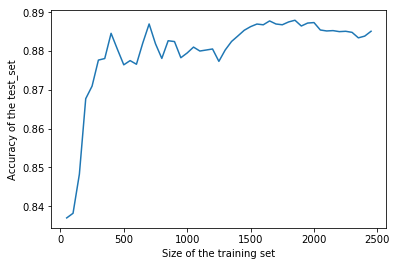

In [35]:
# To find out the performance of the classifer as the size of training set increases
import matplotlib.pyplot as plt

sizes = []
accuracies = []
for size in range(50, 2500, 50):
    sizes.append(size)
    fitted_model = train(training_data[:size,:])

    #testing set prediction and accuracy
    y_predictions_test_set = test(training_data[size:,1:], fitted_model)
    y_true_test_set = training_data[size:,0]
    acc_test_set = accuracy(y_predictions_test_set, y_true_test_set)
    accuracies.append(acc_test_set)
    
plt.plot(sizes, accuracies)
plt.ylabel('Accuracy of the test_set')
plt.xlabel('Size of the training set')
plt.show()

The performance of the classifer increase with increasing the training set, because the model become more generalized and not biased to specific training set.

Experimentation with alternative classifiers:

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis()]

X = training_data[:,1:]
y = training_data[:,0]

for name, svm1 in zip(names, classifiers):
        svm1.fit(X, y)
        print('using {}:' .format(name))
        print('Accuracy of training set: {:.3f}'.format(svm1.score(X, y)))
        print('-----------')

using Nearest Neighbors:
Accuracy of training set: 0.972
-----------
using Linear SVM:
Accuracy of training set: 0.928
-----------
using RBF SVM:
Accuracy of training set: 0.990
-----------
using Decision Tree:
Accuracy of training set: 0.921
-----------
using Random Forest:
Accuracy of training set: 0.841
-----------
using Neural Net:
Accuracy of training set: 0.939
-----------
using AdaBoost:
Accuracy of training set: 0.933
-----------
using QDA:
Accuracy of training set: 0.592
-----------


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
